In [10]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import os
import matplotlib.pyplot as plt

import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
import pickle
from PIL import Image
import numpy as np

## Load Dataset

In [91]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        with open(img_path, 'rb') as handle:
            frame_data = pickle.load(handle)
            image = frame_data['rgb']
            # image = rgb2gray(frame_data['rgb'])
        label = self.img_labels.iloc[idx, 1:].to_numpy(dtype=float)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

def flatten_color(image):
    return image.reshape(-1, image.shape[-1])

In [100]:
annotations_file = "labels.csv"
img_dir = "frames"
training_data = CustomImageDataset(annotations_file, img_dir)
test_data = CustomImageDataset(annotations_file, img_dir)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

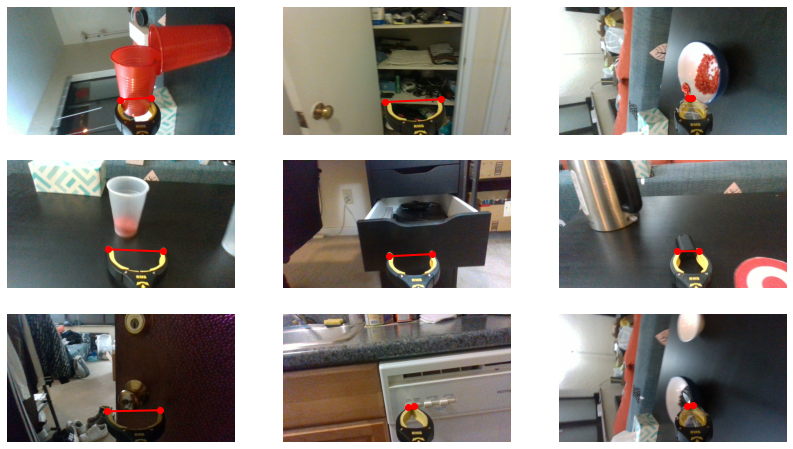

In [101]:
fig = plt.figure(figsize=(14, 8))
i = 0
n = 9
for i in range (n):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    img = img.reshape(720, 1280, 3)
    img = np.flip(img, axis=-1) 
    ax = fig.add_subplot(3, 3, i+1)
    plt.axis('off')
    plt.imshow(img)
    plt.plot([label[0], label[2]], [label[1], label[3]], color='red', marker='o', linewidth=2)

## Networks from robot_baselines

In [96]:
def _linear(in_dim, out_dim, gain=1):
    layer = nn.Linear(in_dim, out_dim)
    nn.init.orthogonal_(layer.weight.data, gain=gain)
    nn.init.constant_(layer.bias.data, 0)
    return layer

class CNNPolicy(nn.Module):
    def __init__(self, features, adim=7, H=1):
        super().__init__()
        self._features = features
        f1, a1 = _linear(256, 256), nn.Tanh()
        f2 = _linear(256, adim * H)
        self._pi = nn.Sequential(f1, a1, f2)
        self._adim, self._H = adim, H
    
    def forward(self, images):
        feat = self._features(images)
        if self._H > 1:
            return self._pi(feat).reshape((-1, self._H, self._adim))
        # import pdb; pdb.set_trace()
        return self._pi(feat).reshape((-1, self._adim))

class VGGSoftmax(nn.Module):
    def __init__(self, bias=None):
        super().__init__()
        c1, a1 = nn.Conv2d(3, 64, 3, stride=1, padding=1), nn.ReLU(inplace=True)
        c2, a2 = nn.Conv2d(64, 64, 3, stride=1, padding=1), nn.ReLU(inplace=True)
        m1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        c3, a3 = nn.Conv2d(64, 128, 3, stride=1, padding=1), nn.ReLU(inplace=True)
        c4, a4 = nn.Conv2d(128, 128, 3, stride=1, padding=1), nn.ReLU(inplace=True)
        self.vgg = nn.Sequential(c1, a1, c2, a2, m1, c3, a3, c4, a4)
        self.extra_convs = nn.Conv2d(128, 128, 3, stride=2, padding=1)

    def forward(self, x):
        # vgg convs and 2D softmax
        x = self.vgg(x)
        x = self.extra_convs(x)
        B, C, H, W = x.shape
        x = F.softmax(x.view((B, C, H * W)), dim=2).view((B, C, H, W))

        # calculate and return expected keypoints
        h = torch.linspace(-1, 1, H).reshape((1, 1, -1)).to(x.device) * torch.sum(x, 3)
        w = torch.linspace(-1, 1, W).reshape((1, 1, -1)).to(x.device) * torch.sum(x, 2)
        return torch.cat([torch.sum(a, 2) for a in (h, w)], 1)

In [97]:
class Arguments:
    def __init__(self, **kwargs):
        args = self.default
        for k in kwargs.keys():
            if k not in args:
                print("WARNING: key {} not in defaults!".format(k))

        args.update(kwargs)
        for k, v in args.items():
            setattr(self, k, v)
    
    def default(self):
        raise NotImplementedError

class Metric:
    def __init__(self):
        self.reset()

    def reset(self):
        self._n = 0
        self._value = 0
    
    def add(self, value):
        self._value += value
        self._n += 1
    
    @property
    def mean(self):
        if self._n:
            return self._value / self._n
        return 0

## robot_baselines train code

In [98]:
def train(args):
    # create output folder
#     if not os.path.exists(args.output_folder):
#         os.makedirs(args.output_folder)

    # load dataset depending on arguments
#     if args.TRAJ:
#         train, test = baselines.datasets.traj_dataset(args.input_data, args.BATCH_SIZE)
#     elif args.H == 1:
#         train, test, _ = baselines.datasets.state_action_dataset(args.input_data, args.BATCH_SIZE)
#     else:
#         train, test = baselines.datasets.snippet_dataset(args.input_data, args.BATCH_SIZE, args.H)

    train = train_dataloader
    test = test_dataloader
  
    # build network and restore weights
    features = VGGSoftmax()
    Model = CNNPolicy
    policy = Model(features, H=args.H).cuda()


    # build optim
    train_metric, test_metric = Metric(), Metric()
    optim = torch.optim.Adam(policy.parameters(), lr=args.LR)
    loss = nn.SmoothL1Loss()
    for e in range(args.EPOCHS):
        train_metric.reset(); test_metric.reset()
        policy = policy.train()
        for image, label in train:
            optim.zero_grad()
            pred = policy(image.cuda())
            train_loss = loss(pred, label.cuda())
            train_loss.backward()
            optim.step()
            train_metric.add(train_loss.item())
            print('epoch {} \t train {:.6f} \t\t'.format(e, train_loss.item()), end='\r')
        
#         policy = policy.eval()
#         for i, s, acs in test:
#             with torch.no_grad():
#                 acs_hat = policy(i.cuda(), s.cuda())
#                 test_metric.add(loss(acs_hat, acs.cuda()).item())
#         print('epoch {} \t train {:.6f} \t test {:.6f}'.format(e, train_metric.mean, test_metric.mean))

#         if (e + 1) % args.SAVE_FREQ == 0 or e + 1 == args.EPOCHS:
#             torch.save(policy.state_dict(), args.output_folder + '/policy_epoch{}.pt'.format(e))



In [99]:
class Arguments(Arguments):
    @property
    def default(self):
        return {
            'BATCH_SIZE': 64,
            'EPOCHS': 100,
            'LR': 1e-3,
            'H': 1,
        }
    
train(Arguments())

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 3, 3], but got 3-dimensional input of size [64, 921600, 3] instead

## PyTorch tutorials train code

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")